<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> Leshy (Boruta evolution), BoostAGroota (BoostAGroota evolution), GrootCV (new) </h2>
<p style="text-align:center">
   Human Bender<br>
</p>

<div align="center">
    <img border="0" src="bender_hex_mini.png" width="100px" align="center" />
</div>


<h2 style="color:#deab02;">Introduction</h2>

<h3 style="color:#deab02;">All relevant feature selection - comparison and testing </h3>

All relevant feature selection means trying to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some particular model has a minimal error. This might include redundant predictors. All relevant feature selection is model agnostic in the sense that it doesn't optimize a scoring function for a *specific* model but rather tries to select all the predictors which are related to the response. 


<h4 style="color:#deab02;"> Boruta </h4>
The Boruta algorithm tries to capture all the important features you might have in your dataset with respect to an outcome variable. The procedure is the following:

 * Create duplicate copies of all independent variables. When the number of independent variables in the original data is less than 5, create at least 5 copies using existing variables.
 * Shuffle the values of added duplicate copies to remove their correlations with the target variable. It is called shadow features or permuted copies.
 * Combine the original ones with shuffled copies
 * Run a random forest classifier on the combined dataset and performs a variable importance measure (the default is Mean Decrease Accuracy) to evaluate the importance of each variable where higher means more important.
 * Then Z score is computed. It means mean of accuracy loss divided by the standard deviation of accuracy loss.
 * Find the maximum Z score among shadow attributes (MZSA)
 * Tag the variables as 'unimportant' when they have importance significantly lower than MZSA. Then we permanently remove them from the process.
 * Tag the variables as 'important' when they have importance significantly higher than MZSA.
 * Repeat the above steps for a predefined number of iterations (random forest runs), or until all attributes are either tagged 'unimportant' or 'important', whichever comes first.

At every iteration, the algorithm compares the Z-scores of the shuffled copies of the features and the original features to see if the latter performed better than the former. If it does, the algorithm will mark the feature as important. In essence, the algorithm is trying to validate the importance of the feature by comparing with randomly shuffled copies, which increases the robustness. This is done by simply comparing the number of times a feature did better with the shadow features using a binomial distribution. Since the whole process is done on the same train-test split, the variance of the variable importance comes only from the different re-fit of the model over the different iterations.


<h4 style="color:#deab02;"> BoostARoota </h4>
BoostARoota follows closely the Boruta method but modifies a few things:

 * One-Hot-Encode the feature set
 * Double width of the data set, making a copy of all features in the original dataset
 * Randomly shuffle the new features created in (2). These duplicated and shuffled features are referred to as "shadow features"
 * Run XGBoost classifier on the entire data set ten times. Running it ten times allows for random noise to be smoothed, resulting in more robust estimates of importance. The number of repeats is a parameter than can be changed.
 * Obtain importance values for each feature. This is a simple importance metric that sums up how many times the particular feature was split on in the XGBoost algorithm.
 * Compute "cutoff": the average feature importance value for all shadow features and divide by four. Shadow importance values are divided by four (parameter can be changed) to make it more difficult for the variables to be removed. With values lower than this, features are removed at too high of a rate.
 * Remove features with average importance across the ten iterations that is less than the cutoff specified in (6)
 * Go back to (2) until the number of features removed is less than ten per cent of the total.
 * Method returns the features remaining once completed.

In the spirit, the same heuristic than Boruta but using Boosting (originally Boruta was supporting only random forest). The validation of the importance is done by comparing to the maximum of the median var. imp of the shadow predictors (in Boruta, a statistical test is performed using the Z-score). Since the whole process is done on the same train-test split, the variance of the variable importance comes only from the different re-fit of the model over the different iterations.

 
<h4 style="color:#deab02;"> Modifications to Boruta and BoostARoota </h4>
 I forked both Boruta and BoostARoota and made the following changes (under PR):
 
**Boruta --> Leshy**:
 
  - The categorical features (they are detected, encoded. The tree-based models are working better with integer encoding rather than with OHE, which leads to deep and unstable trees). If Catboost is used, then the cat.pred (if any) are set up
  - Using lightGBM as the default speeds up by an order of magnitude the running time
  - Work with Catboost, sklearn API
  - Allow using sample_weight, for applications like Poisson regression or any requiring weights
  - Supports 3 different feature importances: native, SHAP and permutation. Native being the least consistent(because of the imp. biased towards numerical and large cardinality categorical) but the fastest of the 3. Indeed, the impurity var.imp. are biased en sensitive to large cardinality (see [scikit demo](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py))
  
**BoostARoota --> BoostAGroota**:

  - Replace XGBoost with LightGBM, you can still use tree-based scikitlearn models
  - Replace native var.imp by SHAP var.imp. Indeed, the impurity var.imp. are biased en sensitive to large cardinality (see [scikit demo](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)). Moreover, the native var. imp are computed on the train set, here the data are split (internally) in train and test, var. imp computed on the test set.
  - Handling categorical predictors. Cat. predictors should NOT be one-hot encoded, it leads to deep unstable trees. Instead, it's better to use the native method of lightGBM or CatBoost. A preprocessing step is needed to encode (ligthGBM and CatBoost use integer encoding and reference to categorical columns. The splitting strategies are different then, see official doc).
  - Work with sample_weight, for Poisson or any application requiring a weighting.
 
<h4 style="color:#deab02;"> GrootCV, a new method </h4>
 
**New: GrootCV**:
   - Cross-validated feature importance to smooth out the noise, based on lightGBM only (which is, most of the time, the fastest and more accurate Boosting).
   - the feature importance is derived using SHAP importance
   - Taking the max of median of the shadow var. imp over folds otherwise not enough conservative and it improves the convergence (needs less evaluation to find a threshold)
   - Not based on a given percentage of cols needed to be deleted
   - Plot method for var. imp
 

<h4 style="color:#deab02;"> References </h4>

**Theory**
 - [Consistent feature selection for pattern recognition in polynomial time](http://compmed.se/files/6914/2107/3475/pub_2007_5.pdf)

**Applications**
 - [The Boruta paper]([https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf)
 - [The python implementation](https://github.com/scikit-learn-contrib/boruta_py)
 - [BoostARoota](https://github.com/chasedehan/BoostARoota)



<h2 style="color:#deab02;">1 - Configuration, Loading the packages, data and utilities definition </h2>
 

First let's set the libraries, general settings and define some functions (in the notebook for convenience, will be moved in a library during a later stage).

## Packages

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Settings and libraries
from __future__ import print_function

# pandas
import pandas as pd
#import pandas_profiling as pp
#import modin.pandas as pd # high perf and distributed version of pandas based on RAY

# pyarrow and parquet
import pyarrow as pa
import pyarrow.parquet as pq

# SAS and other legacies
import pyreadstat

# Plot and graphics
import seaborn as sns
sns.set(style="ticks")
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from mpl_toolkits import mplot3d
import palettable as pal
from palettable.cartocolors.sequential import Sunset_7_r, agSunset_7, SunsetDark_7, SunsetDark_2, Sunset_2, SunsetDark_2_r, Sunset_2_r, SunsetDark_5
from palettable.cartocolors.qualitative import Bold_10
from palettable.cmocean.sequential import Matter_20_r, Thermal_20, Matter_8, Matter_20
from palettable.cmocean.diverging import Curl_19, Balance_19, Curl_5, Curl_5_r
import cmocean



# Utilities
import time
from sys import getsizeof, path
import psutil
import random
import importlib
import gc
from tqdm import tnrange, tqdm_notebook
import re
import json


# lightgbm and catboost
#import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier



import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot

In [3]:
from bokeh.themes.theme import Theme
import holoviews as hv

theme = Theme(
    json={
    'attrs' : {
        'Figure' : {
            'background_fill_color': '#2F2F2F',
            'border_fill_color': '#2F2F2F',
            'outline_line_color': '#444444',
        },
        'Grid': {
            'grid_line_dash': [6, 4],
            'grid_line_alpha': .3,
        },

        'Axis': {
            'major_label_text_color': 'white',
            'axis_label_text_color': 'white',
            'major_tick_line_color': 'white',
            'minor_tick_line_color': 'white',
            'axis_line_color': "white"
        }
    }
})

monokai = Theme(
    json={
### Monokai-inspired Bokeh Theme
# written July 23, 2017 by Luke Canavan

### Here are some Monokai palette colors for Glyph styling
# @yellow: "#E6DB74"
# @blue: "#66D9EF"
# @pink: "#F92672"
# @purple: "#AE81FF"
# @brown: "#75715E"
# @orange: "#FD971F"
# @light-orange: "#FFD569"
# @green: "#A6E22E"
# @sea-green: "#529B2F"

'attrs':{
    'Axis':{
        'axis_line_color': "#49483E",
        'axis_label_text_color': "#adadad",
        'major_label_text_color': "#adadad",
        'major_tick_line_color': "#49483E",
        'minor_tick_line_color': "#49483E"
    },
    'Grid':{
        'grid_line_color': "#49483E"
    },
   'Legend':{
        'border_line_color': "#49483E",
        'background_fill_color': "#282828",
        'label_text_color': "#adadad"
    },
    'Plot':{
       'background_fill_color': "#282828",
        'border_fill_color': "#282828",
        'outline_line_color': "#49483E"
    },
    'Title':{
        'text_color': "#CCCCCC"
    } }})

hv.renderer('bokeh').theme = monokai

In [4]:
%matplotlib inline

In [5]:
gc.enable()
gc.collect()

26

<h2 style="color:#deab02;"> Testing and comparing Leshy and BoostAGroota </h2>

==================== Benchmarking using sklearn permutation importance ====================


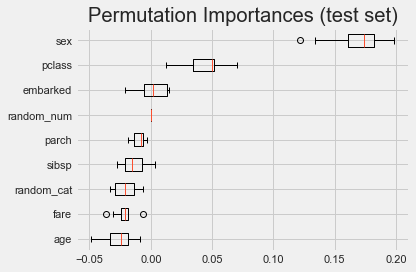

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	2
All relevant predictors selected in 00:00:30.95
['pclass', 'sex', 'embarked', 'parch', 'fare']


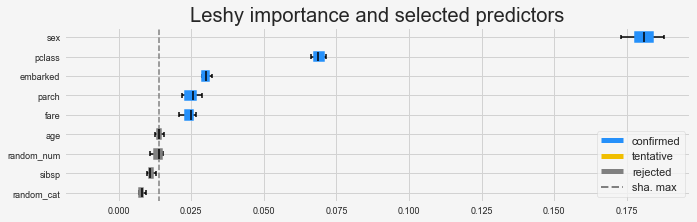

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F77356A48> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:05.44
['pclass', 'sex', 'embarked', 'parch', 'fare']


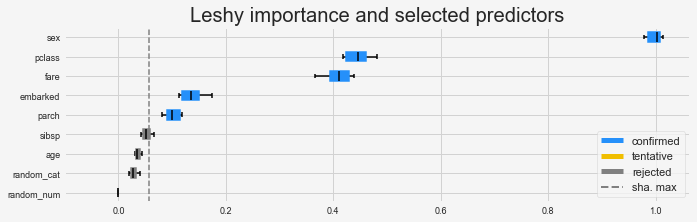

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	1
Rejected: 

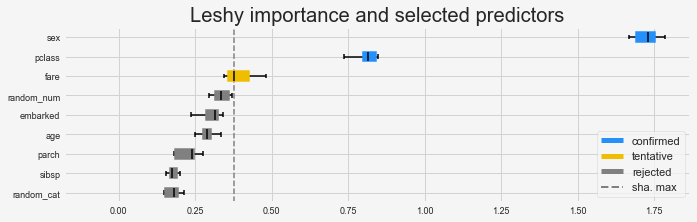

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:04.23
['pclass', 'sex']


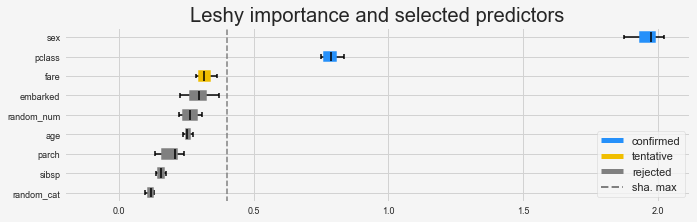

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

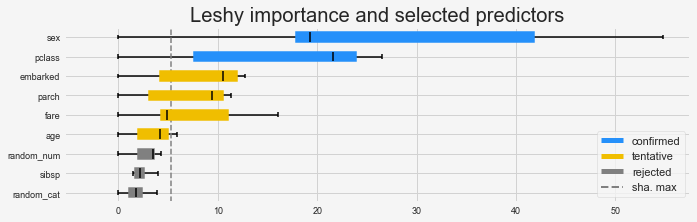

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 	0
All relevant predictors selected in 00:00:23.70
['pclass', 'sex']


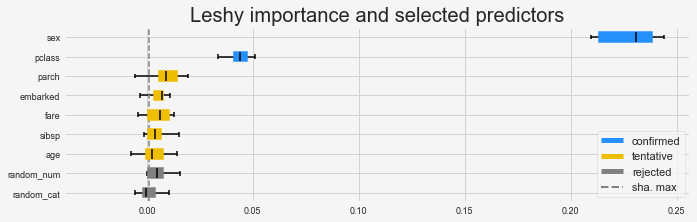

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F773E7148> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	1
All relevant predictors selected in 00:00:08.78
['pclass', 'sex', 'fare']


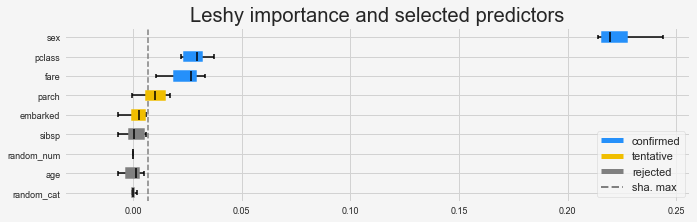

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 

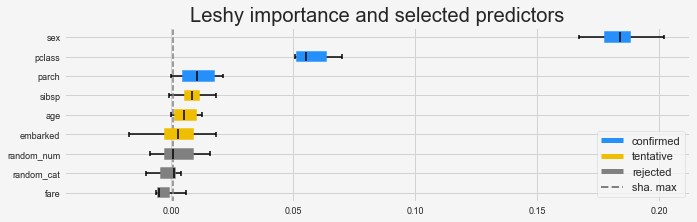

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	0
All relevant predictors selected in 00:00:03.36
['pclass', 'sex']


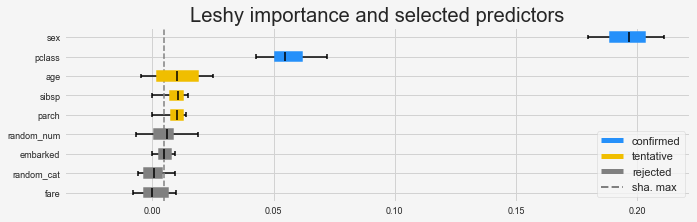

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

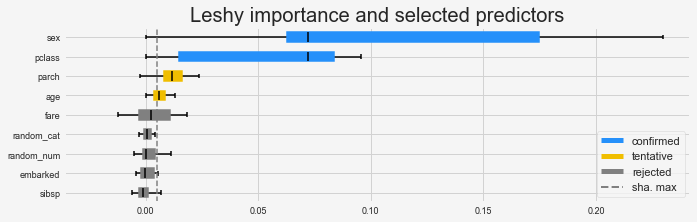

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:03.59
['sex', 'fare', 'random_num']


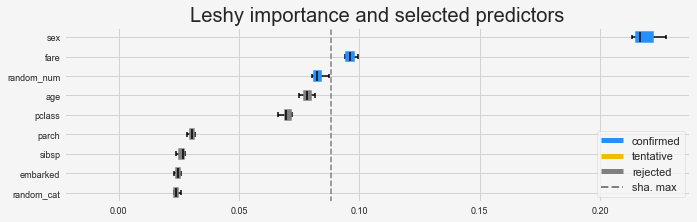

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F773D1908> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:04.89
['pclass', 'sex', 'parch', 'fare']


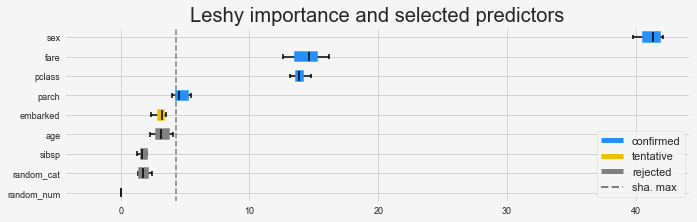

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected

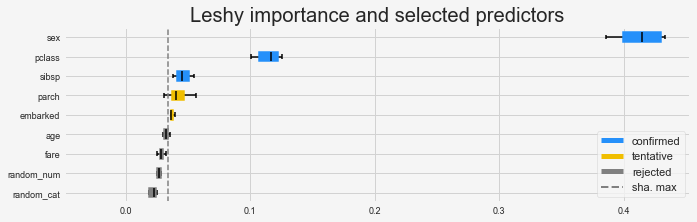

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	1
Rejected: 	7
All relevant predictors selected in 00:00:00.74
['random_num']


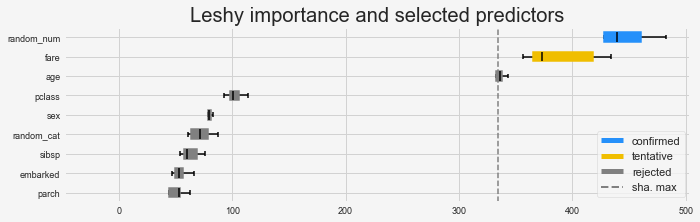

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:00.53
[]


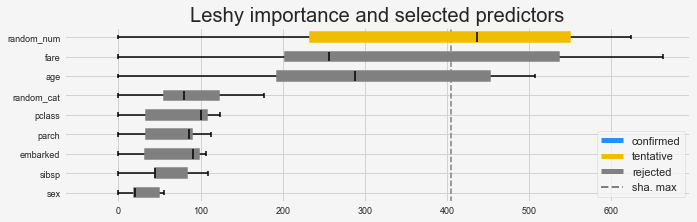

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	22
Tentative: 	3
Rejected: 	2
All relevant predictors selected in 00:00:03.23
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'concavity error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


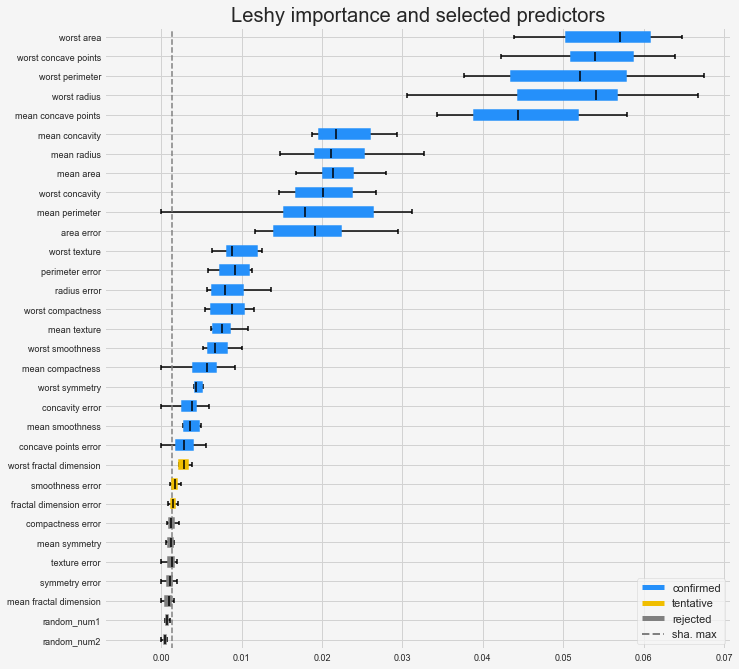

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F776E86C8> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	18
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:07.89
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean concavity', 'mean concave points', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


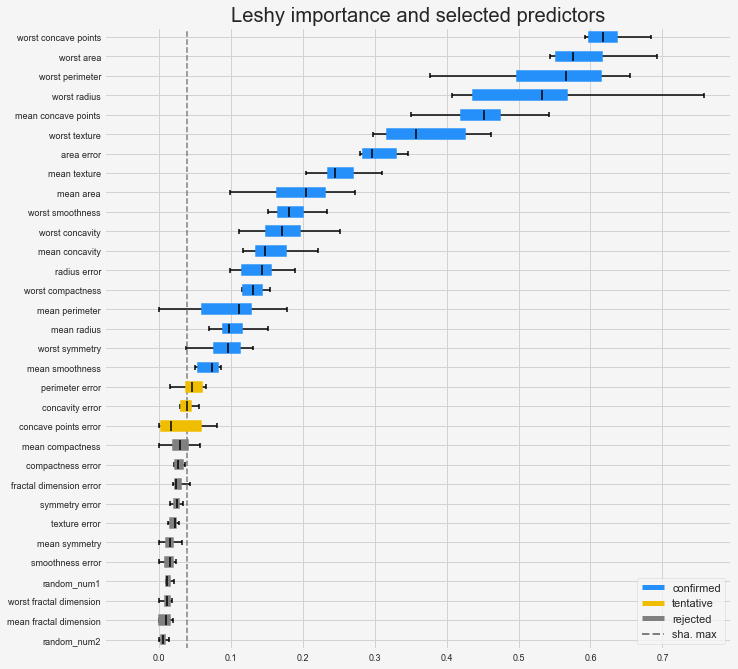

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	3
Rejected:

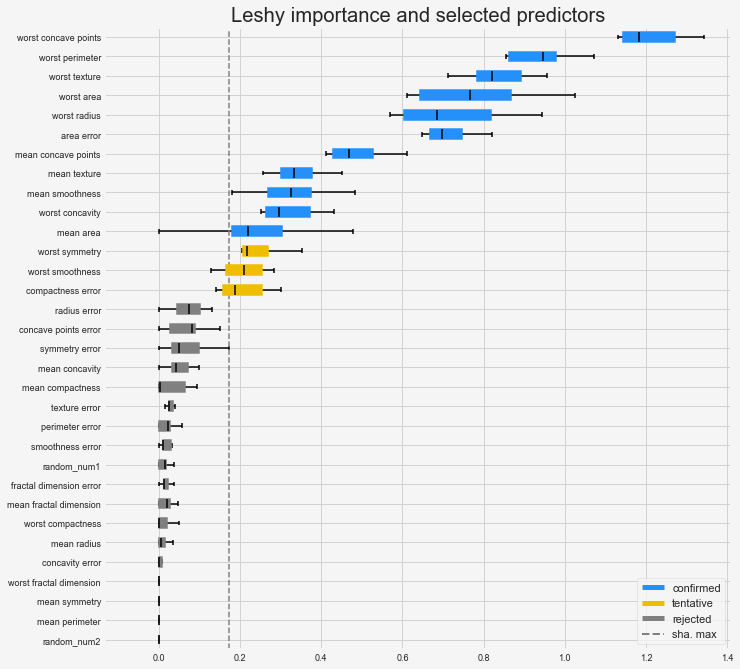

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	12
Tentative: 	4
Rejected: 	13
All relevant predictors selected in 00:00:03.19
['mean texture', 'mean area', 'mean smoothness', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']


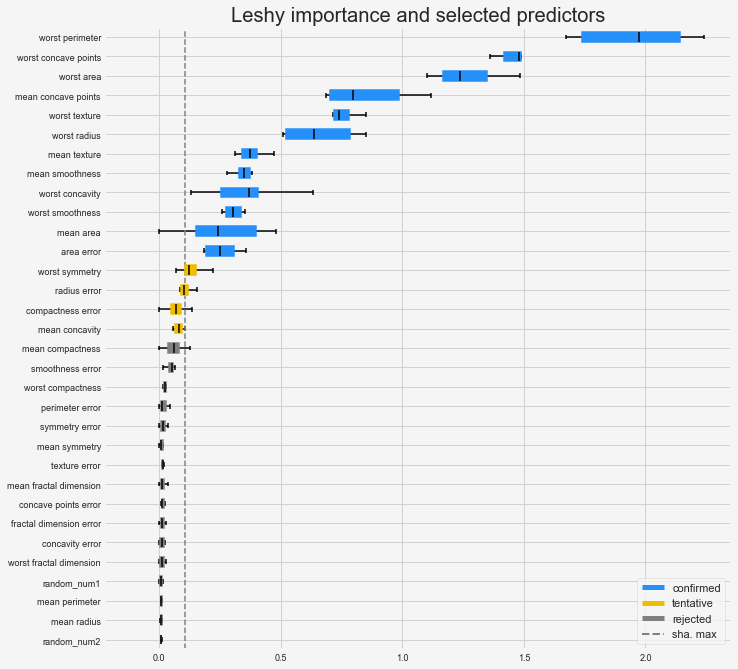

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

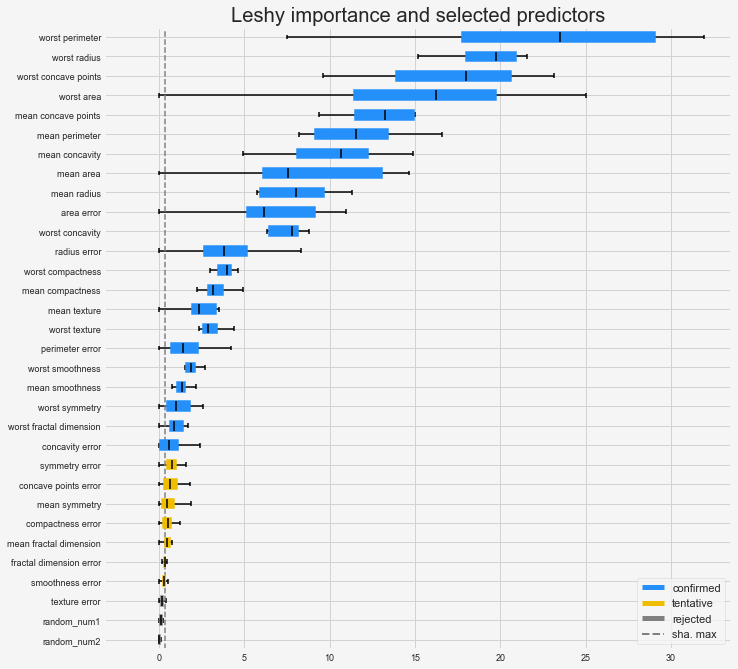

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	12
All relevant predictors selected in 00:00:45.88
[]


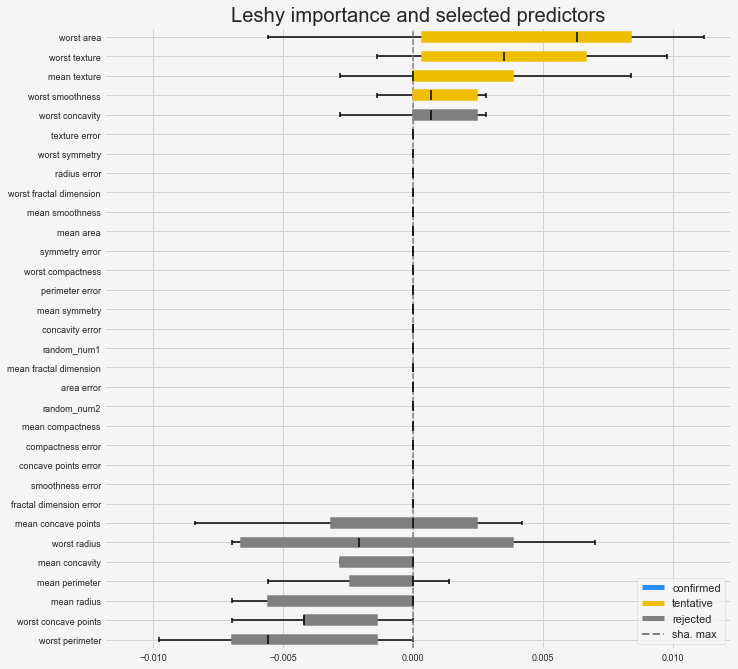

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F774ECD48> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	2
Rejected: 	17
All relevant predictors selected in 00:00:15.90
['worst texture']


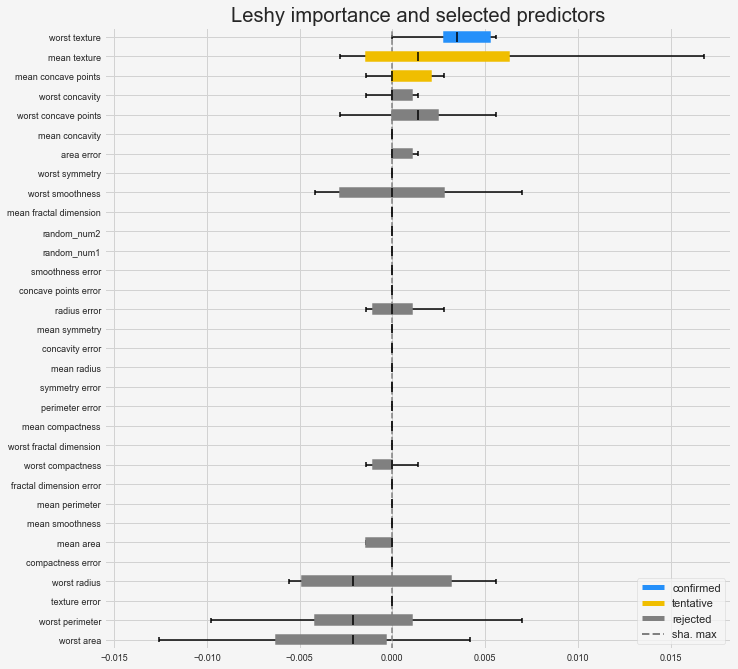

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 

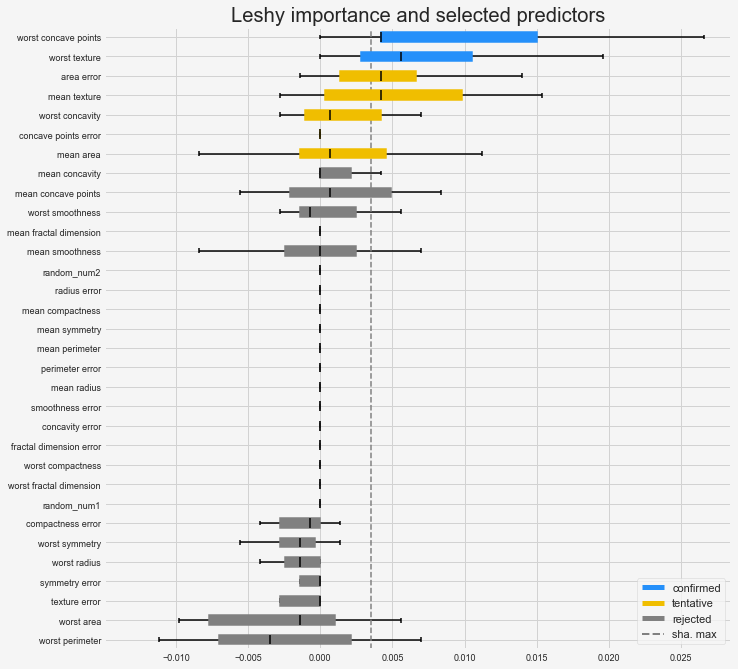

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	6
Rejected: 	14
All relevant predictors selected in 00:00:06.61
['worst texture', 'worst perimeter', 'worst concave points']


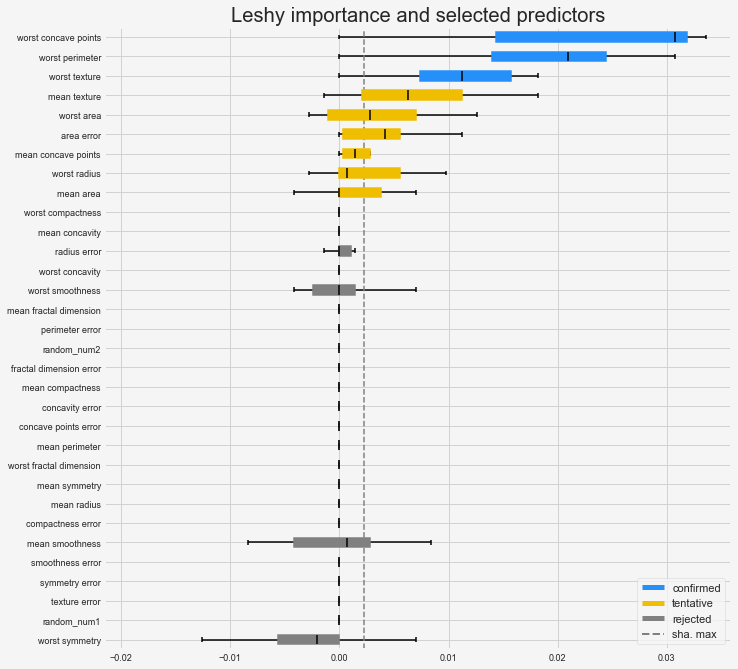

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

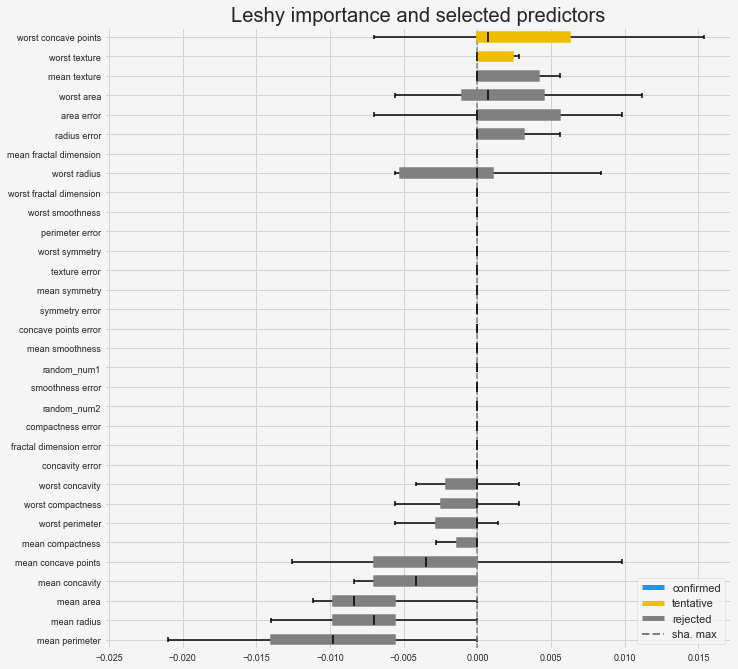

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	22
Tentative: 	8
Rejected: 	2
All relevant predictors selected in 00:00:03.39
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'concavity error', 'concave points error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


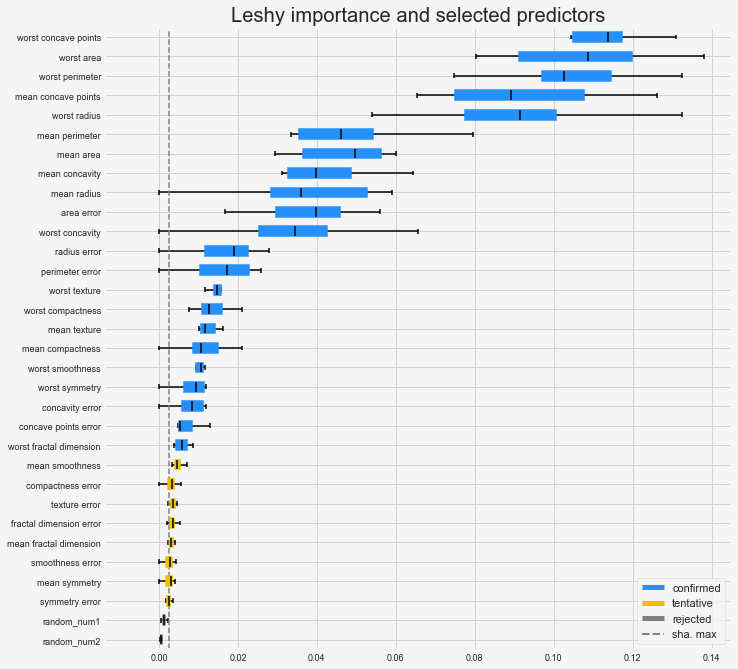

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x0000018F77246D48> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	13
Tentative: 	4
Rejected: 	7
All relevant predictors selected in 00:00:07.13
['mean texture', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


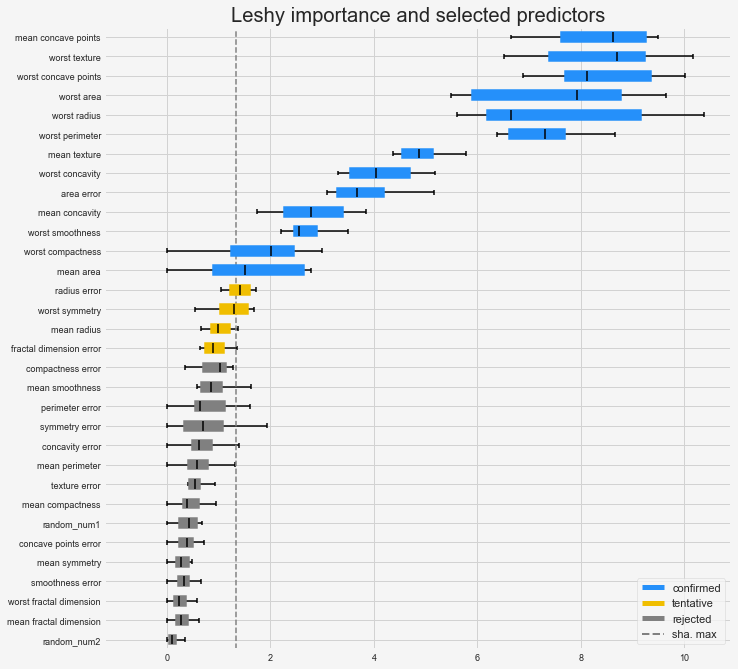

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	2
Rejecte

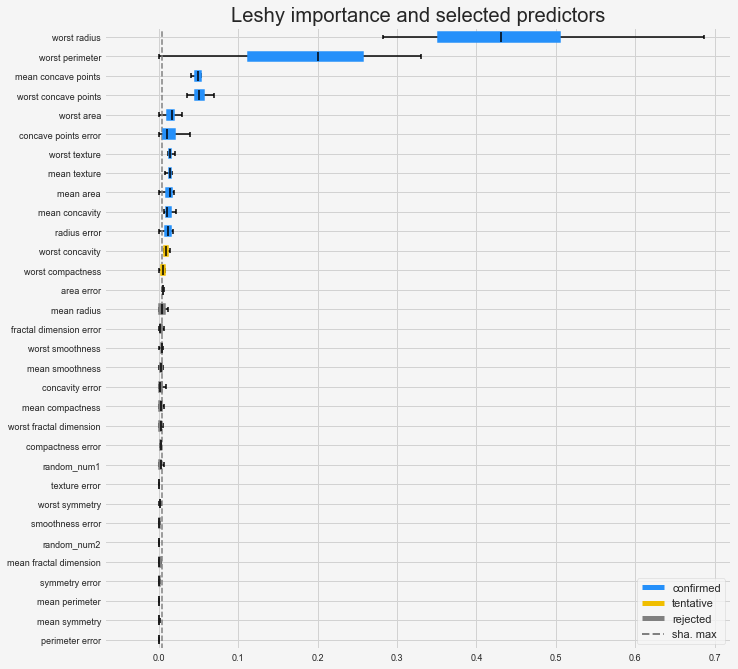

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	4
Rejected: 	10
All relevant predictors selected in 00:00:01.22
['mean texture', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points']


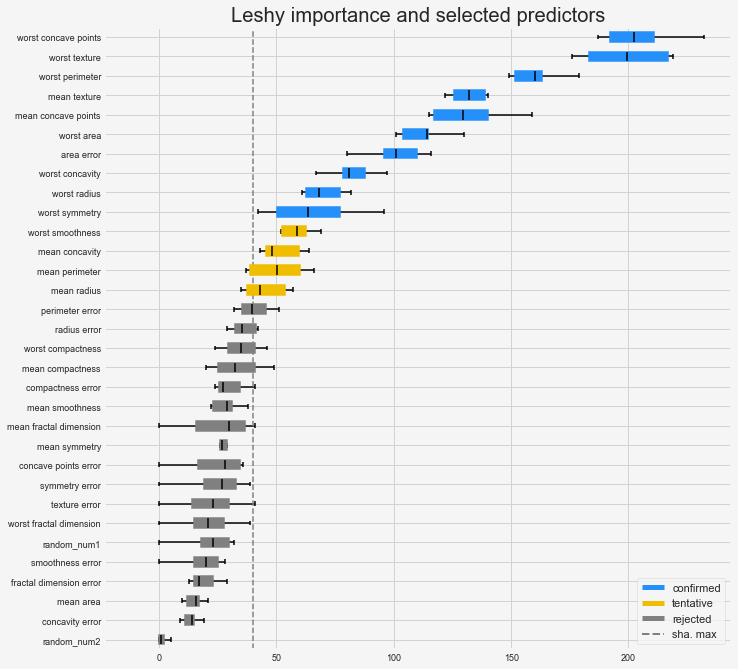

==================== Leshy - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	24
Tentative: 	7
Rejected: 	0
All relevant predictors selected in 00:00:00.28
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'concavity error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst

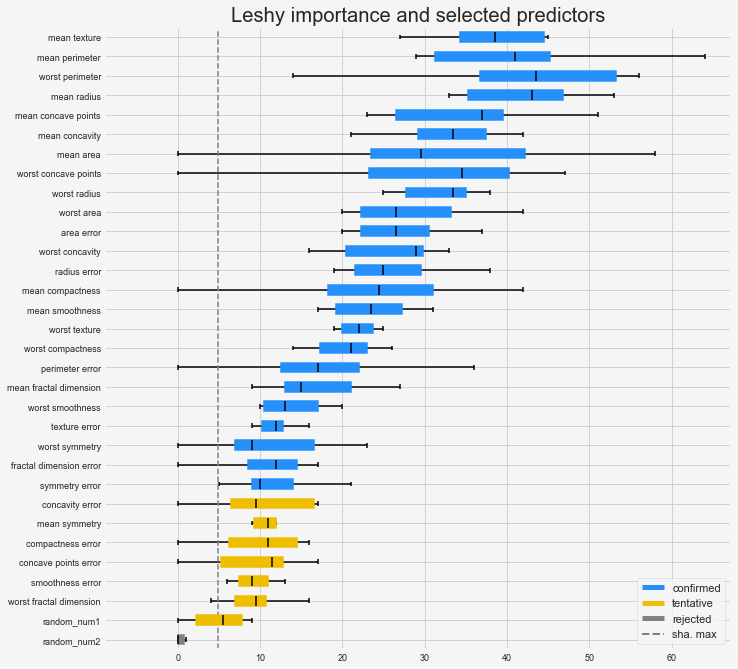

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:12.96
[0, 4, 5, 6, 7, 9, 10, 11, 12, 'random_num1']


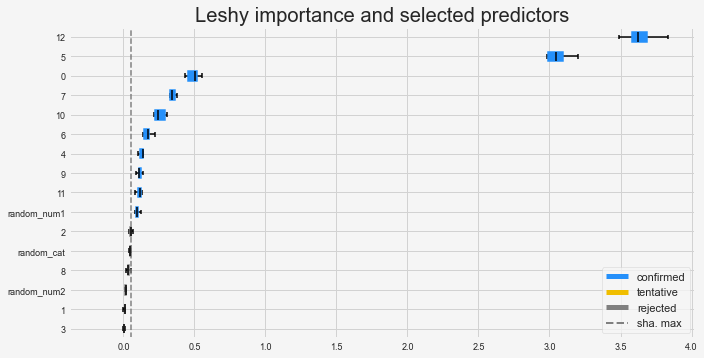

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F773D1C88> for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	8
All relevant predictors selected in 00:00:07.71
[1, 4, 8]


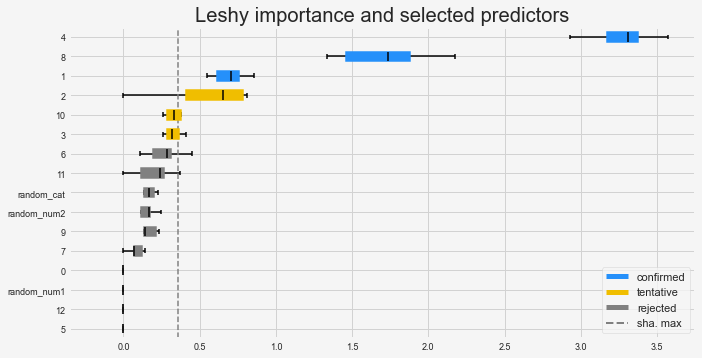

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	8
Tentative: 	4
Rejected: 	4
All re

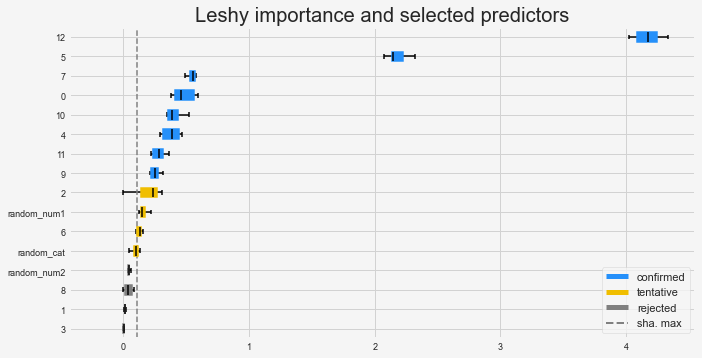

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: shap            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:02.13
[0, 4, 5, 6, 7, 9, 10, 11, 12]


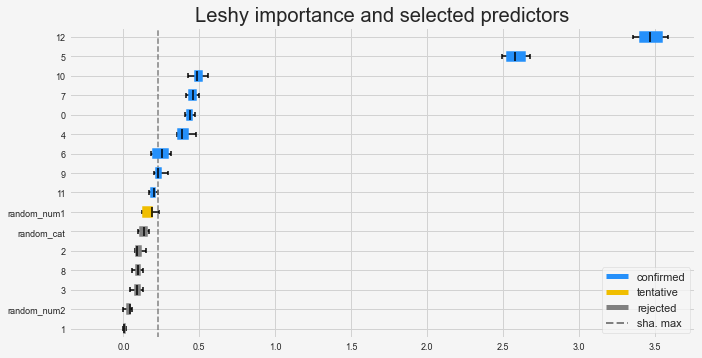

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: shap            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wil

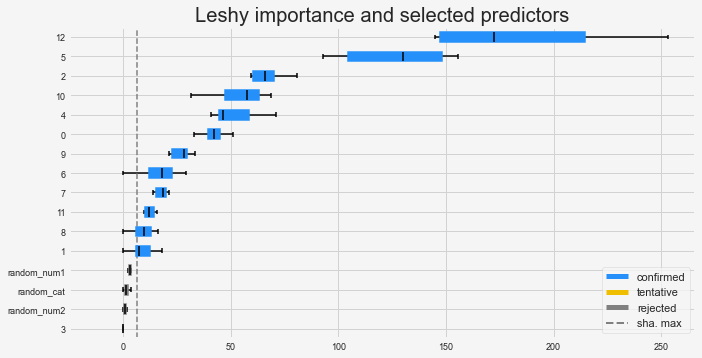

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:29.62
[0, 4, 5, 6, 7, 9, 10, 11, 12]


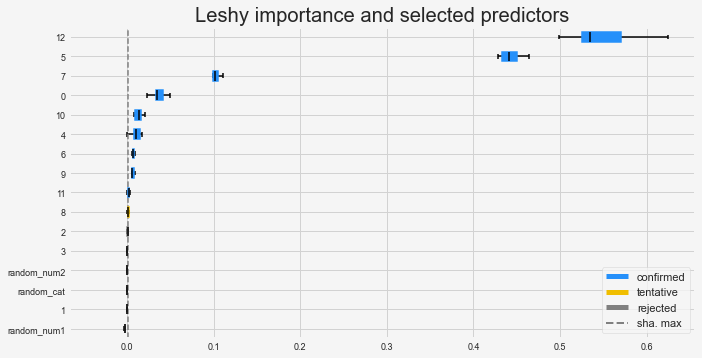

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F777023C8> for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	5
Rejected: 	5
All relevant predictors selected in 00:00:14.44
[1, 4]


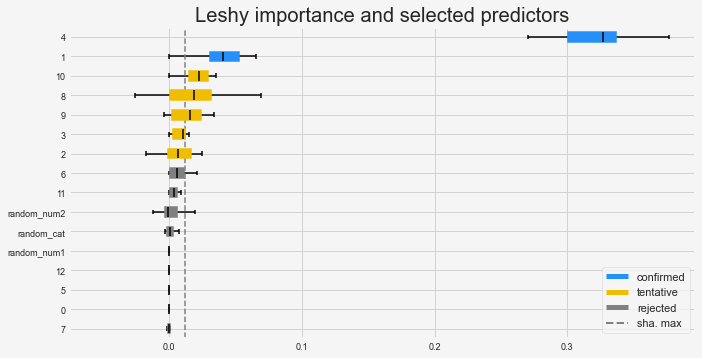

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	4
All re

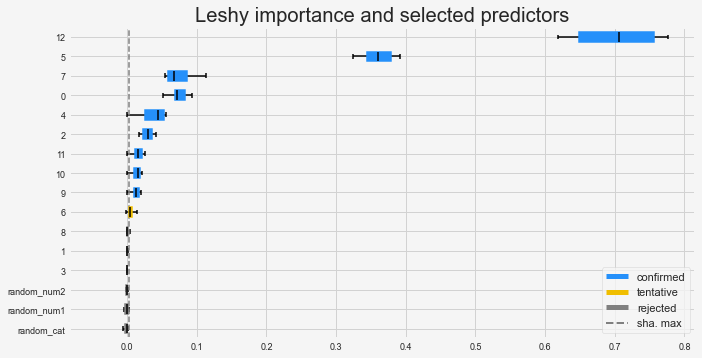

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: pimp            ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	2
Rejected: 	2
All relevant predictors selected in 00:00:03.91
[0, 4, 5, 7, 9, 10, 12]


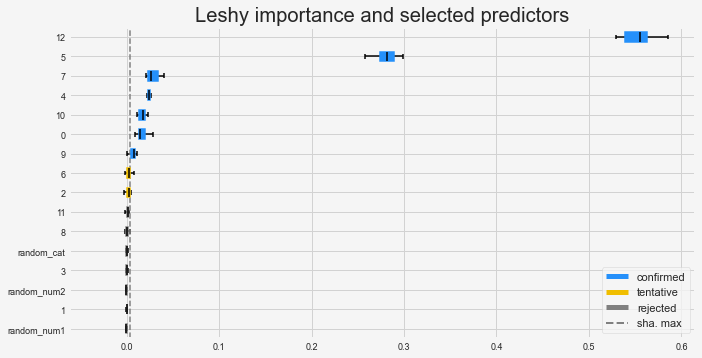

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: pimp            ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Iteration: 1 / 10
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wil

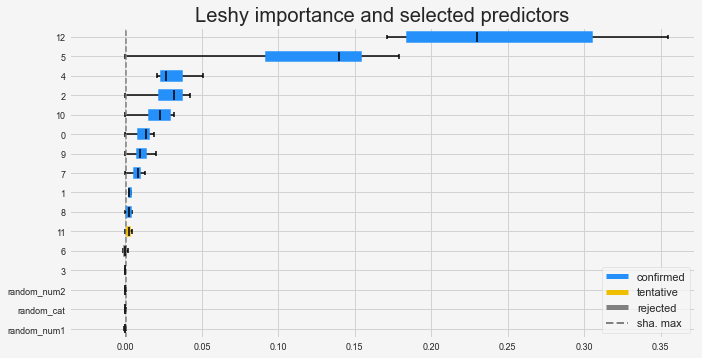

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:04.25
[0, 4, 5, 6, 7, 9, 10, 11, 12]


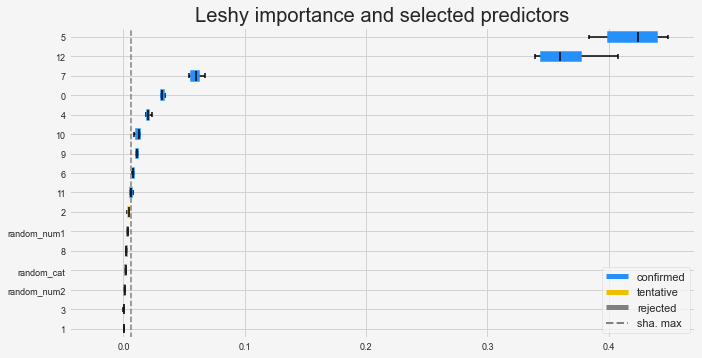

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000018F77272108> for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:07.16
[1, 2, 4, 8]


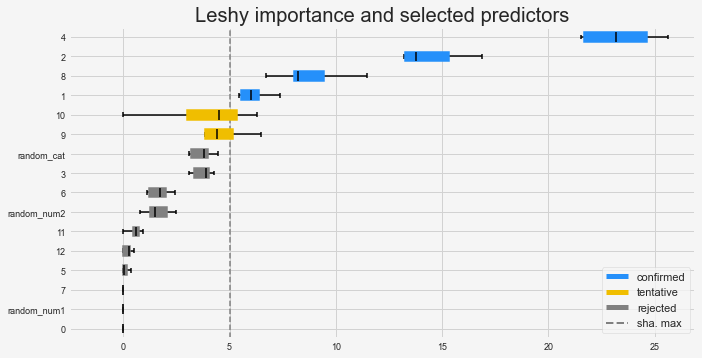

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	2
All 

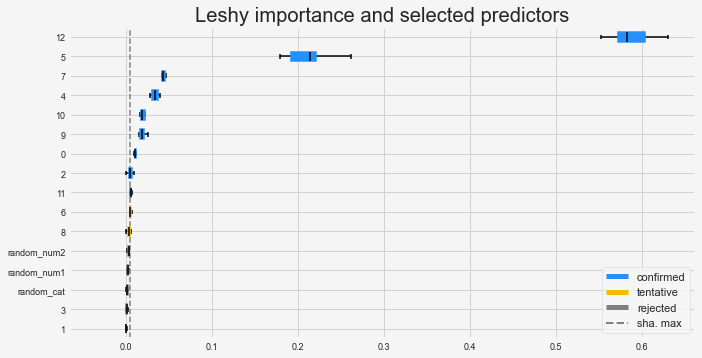

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	6
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:00.50
[0, 4, 5, 6, 7, 12]


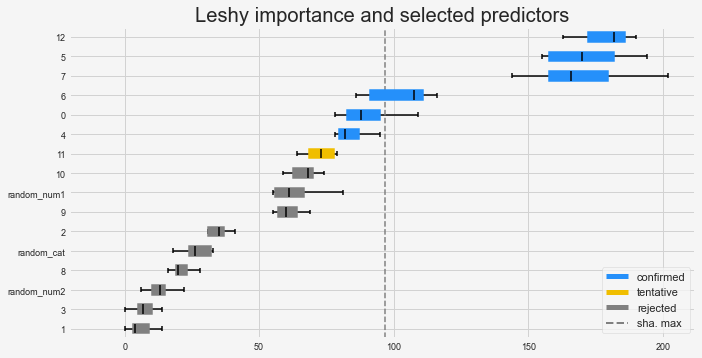

==================== Leshy - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) for var.imp: native          ====================
Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	10
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:00.24
[0, 2, 4, 5, 6, 7, 9, 10, 11, 12]


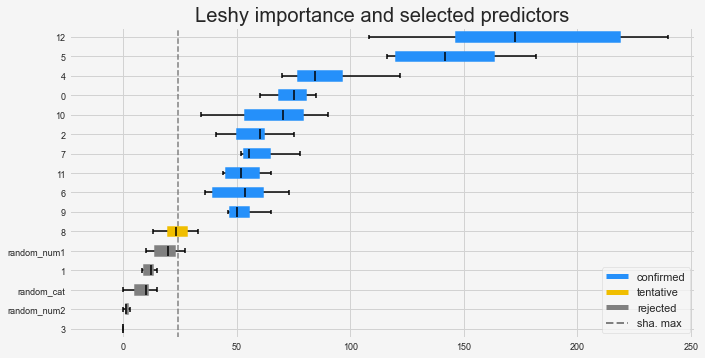

In [6]:
%matplotlib inline
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
# lightgbm and catboost
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

# Convert the cat. pred. for boosting
def cat_var(df, col_excl=None, return_cat=True):
    """Identify categorical features.

        Parameters
        ----------
        df: original df after missing operations

        Returns
        -------
        cat_var_df: summary df with col index and col name for all categorical vars
        :param return_cat: Boolean, return encoded cols as type 'category'
        :param df: pd.DF, the encoded data-frame
        :param col_excl: list, colums not to be encoded
        """

    if col_excl is None:
        non_num_cols = list(set(list(df.columns)) - set(list(df.select_dtypes(include=[np.number]))))
    else:
        non_num_cols = list(
            set(list(df.columns)) - set(list(df.select_dtypes(include=[np.number]))) - set(col_excl))

    # cat_var_index = [i for i, x in enumerate(df[col_names].dtypes.tolist()) if isinstance(x, pd.CategoricalDtype) or x == 'object']
    # cat_var_name = [x for i, x in enumerate(col_names) if i in cat_var_index]

    cat_var_index = [df.columns.get_loc(c) for c in non_num_cols if c in df]

    cat_var_df = pd.DataFrame({'cat_ind': cat_var_index,
                               'cat_name': non_num_cols})

    cols_need_mapped = cat_var_df.cat_name.to_list()
    inv_mapper = {col: dict(enumerate(df[col].astype('category').cat.categories)) for col in df[cols_need_mapped]}
    mapper = {col: {v: k for k, v in inv_mapper[col].items()} for col in df[cols_need_mapped]}

    for c in cols_need_mapped:
        df.loc[:, c] = df.loc[:, c].map(mapper[c]).fillna(0).astype(int)

    if return_cat:
        df[non_num_cols] = df[non_num_cols].astype('category')
    return df, cat_var_df, inv_mapper


def get_titanic_data():
    # Fetch Titanic data and add random cat and numbers
    # Example taken from https://scikit-learn.org/stable/auto_examples/inspection/
    # plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    rng = np.random.RandomState(seed=42)
    X['random_cat'] = rng.randint(3, size=X.shape[0])
    X['random_cat'] = X['random_cat'].astype('str')
    X['random_num'] = rng.randn(X.shape[0])

    categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
    numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']
    X = X[categorical_columns + numerical_columns]
    # Impute
    categorical_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])
    numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
    preprocessing = ColumnTransformer([('cat', categorical_pipe, categorical_columns), ('num', numerical_pipe, numerical_columns)])
    X_trans = preprocessing.fit_transform(X)
    X = pd.DataFrame(X_trans, columns = X.columns)
    # encode
    X, cat_var_df, inv_mapper = cat_var(X)
    # sample weight is just a dummy random vector for testing purpose
    sample_weight = np.random.uniform(0,1, len(y))
    return X, y, sample_weight


def get_cancer_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X = pd.DataFrame(X)
    X.columns = data.feature_names
    X['random_num1'] = rng.randn(X.shape[0])
    X['random_num2'] = np.random.poisson(1, X.shape[0])
    y = pd.Series(y)
    return X, y

def get_boston_data():
    boston = load_boston()
    rng = np.random.RandomState(seed=42)
    X = pd.DataFrame(boston.data)
    X['random_num1'] = rng.randn(X.shape[0])
    X['random_num2'] = np.random.poisson(1, X.shape[0])
    X['random_cat'] = rng.randint(10, size=X.shape[0])
    X['random_cat'] = X['random_cat'].astype('str')
    y = pd.Series(boston.target)
    return X, y


# lightGBM implementation of random forest
# Optimal feature fraction as given by Breiman
def LightForestClassifier(n_feat):
    return lgb.LGBMClassifier(verbose=-1, force_col_wise=True, n_estimators=100, bagging_fraction=0.632,
                                   feature_fraction=np.sqrt(n_feat) / n_feat, boosting_type="rf", bagging_freq=1)

def LightForestRegressor(n_feat):
    return lgb.LGBMRegressor(verbose=-1, force_col_wise=True, n_estimators=100, bagging_fraction=0.632,
                                   feature_fraction=n_feat / (3*n_feat), boosting_type="rf", bagging_freq=1)

# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(varimp, models, X, y, sample_weight=None):
    for model in models:
        print('='*20 +' Leshy - testing: {mod:>55} for var.imp: {vimp:<15} '.format(mod=str(model), vimp=varimp)+'='*20 )
        feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance=varimp)
        feat_selector.fit(X, y, sample_weight)
        print(feat_selector.support_names_)
        feat_selector.plot_importance(n_feat_per_inch=3)
        gc.enable()
        del(feat_selector, model)
        gc.collect()

def testing_clf_all_varimp(X, y, sample_weight=None):
    for varimp in ['shap', 'pimp', 'native']:
        models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
                  catboost.CatBoostClassifier(random_state=42, verbose=0), 
                  XGBClassifier(random_state=42, verbose=0), 
                  LGBMClassifier(random_state=42, verbose=-1),
                  LightForestClassifier(n_feat=X.shape[1])]
        testing_estimators(varimp=varimp, models=models, X=X, y=y, sample_weight=sample_weight)
        gc.enable()
        del(models)
        gc.collect()

def testing_regr_all_varimp(X, y, sample_weight=None):
    for varimp in ['shap', 'pimp', 'native']:
        models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
                  catboost.CatBoostRegressor(random_state=42, verbose=0), 
                  XGBRegressor(random_state=42, verbose=0), 
                  LGBMRegressor(random_state=42, verbose=-1),
                  LightForestRegressor(n_feat=X.shape[1])]
        testing_estimators(varimp=varimp, models=models, X=X, y=y)
        gc.enable()
        del(models)
        gc.collect()
        

print('='*20 + ' Benchmarking using sklearn permutation importance ' + '='*20 )
X, y, sample_weight = get_titanic_data()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weight, stratify=y, random_state=42)
# lightgbm faster and better than RF
lgb_model = LGBMClassifier(n_jobs= 4)
lgb_model.fit(X_train, y_train, sample_weight=w_train)
result = permutation_importance(lgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
# Plot
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight = get_titanic_data() #get_titanic_data()
    testing_clf_all_varimp(X=X, y=y, sample_weight=sample_weight)
     # classification and cat. pred
    X, y = get_cancer_data() #get_titanic_data()
    testing_clf_all_varimp(X=X, y=y)
    # regression
    X, y = get_boston_data()
    testing_regr_all_varimp(X=X, y=y)

# Testing GrootCV

BoostaGroota: classification with unbalance classes
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightG

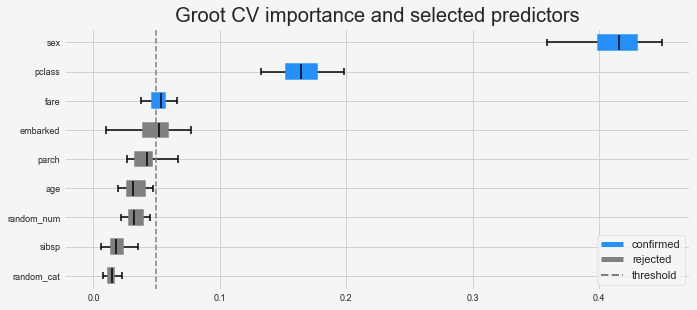

BoostaGroota: classification with unbalance classes
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightG

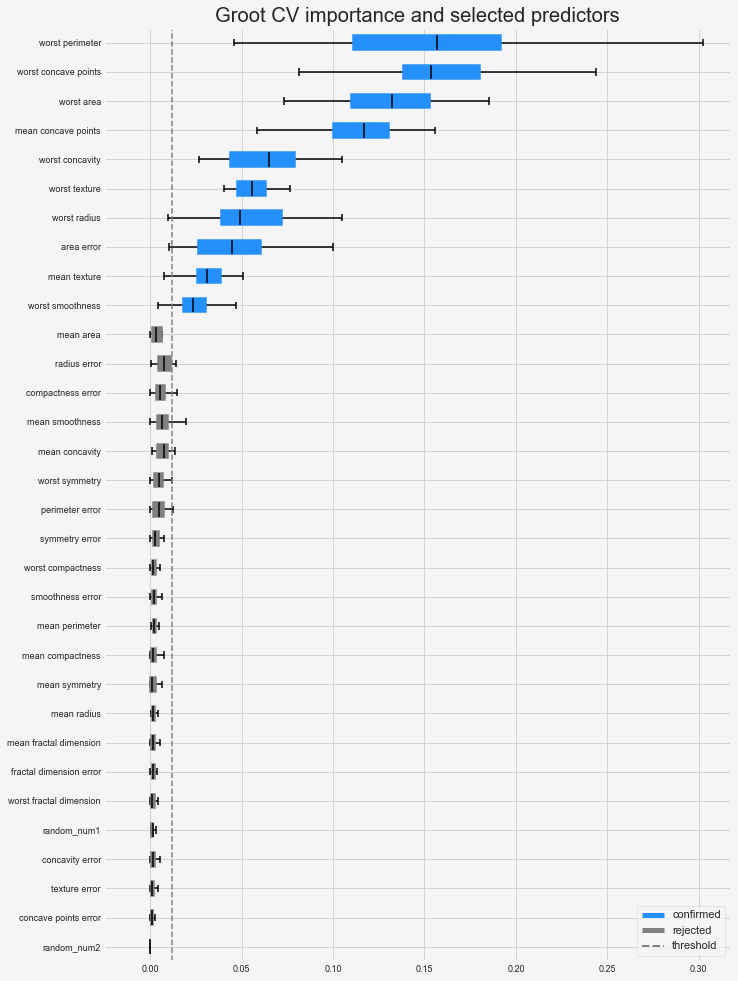

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  0  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Groot iteration:  1  with 5 folds
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be

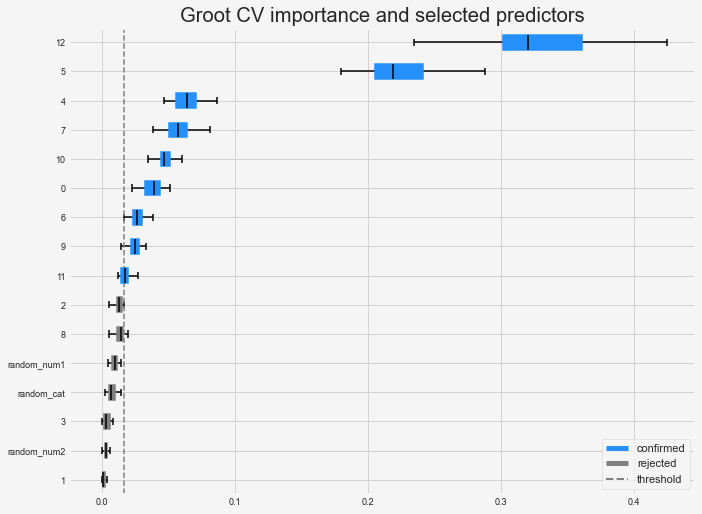

In [7]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='rmse'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5, silent=False)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.keep_vars_ )
    feat_selector.plot_importance(n_feat_per_inch=2)
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight = get_titanic_data() #get_cancer_data():
    testing_estimators(X=X, y=y, sample_weight=sample_weight, objective='binary')
    
    # classification and cat. pred
    X, y = get_cancer_data() #get_cancer_data():
    testing_estimators(X=X, y=y, objective='binary')
    
    # regression
    X, y = get_boston_data()
    testing_estimators(X=X, y=y, objective='rmse')

# Testing BoostAGroota

==================== BoostAGroota - testing:             RandomForestClassifier(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     1.12 min
0      pclass
1         sex
2    embarked
3       parch
4        fare
Name: feature, dtype: object


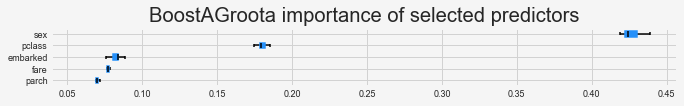

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000018F774E3E48> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     2.07 min
0      pclass
1         sex
2    embarked
3       parch
Name: feature, dtype: object


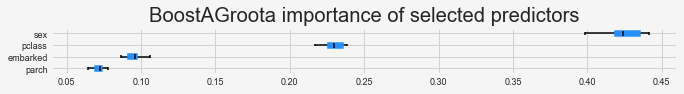

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  itera

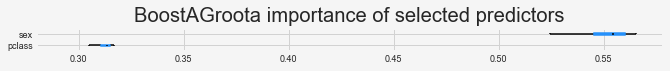

==================== BoostAGroota - testing:                  LGBMClassifier(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.37 min
0    pclass
1       sex
Name: feature, dtype: object


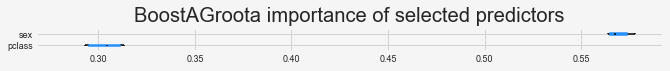

==================== BoostAGroota - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.3333333333333333, force_col_wise=True,
               verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

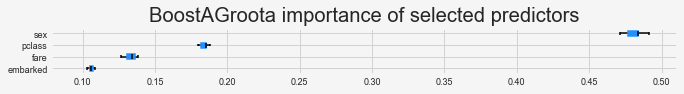

==================== BoostAGroota - testing:             RandomForestClassifier(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.17 min
0                 mean radius
1                mean texture
2              mean perimeter
3                   mean area
4             mean smoothness
5            mean compactness
6              mean concavity
7         mean concave points
8 

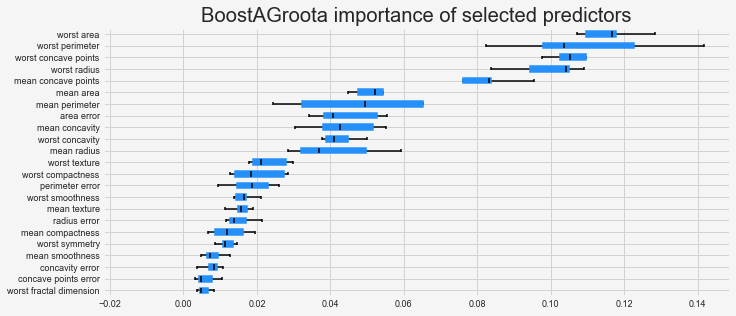

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000018F6CE96C08> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
BoostARoota ran successfully! Algorithm went through  3  rounds.

The feature selection BoostARoota running time is  

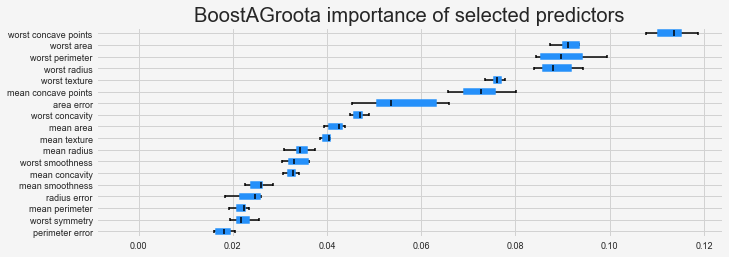

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  itera

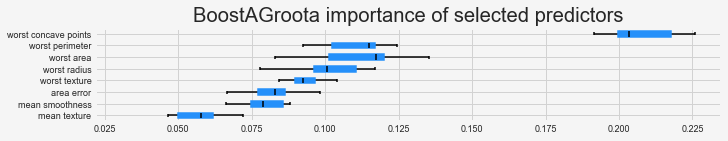

==================== BoostAGroota - testing:                  LGBMClassifier(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.11 min
0             mean texture
1                mean area
2          mean smoothness
3      mean concave points
4               area error
5             worst radius
6            worst texture
7          worst perimeter
8               worst area

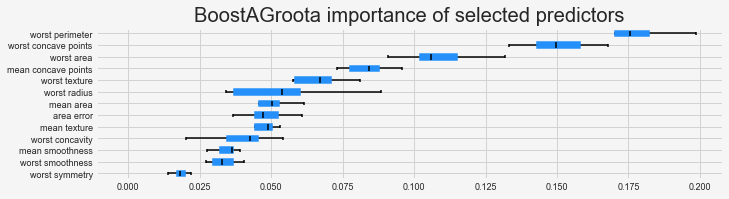

==================== BoostAGroota - testing: LGBMClassifier(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
               feature_fraction=0.1767766952966369, force_col_wise=True,
               verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.1767766952966369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1767766952966369
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

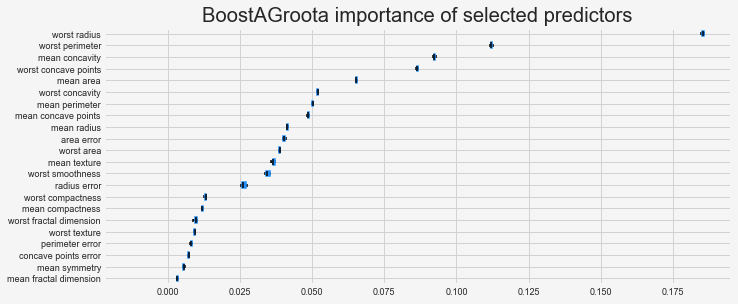

==================== BoostAGroota - testing:              RandomForestRegressor(n_jobs=4, oob_score=True) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     0.48 min
0              0
1              4
2              5
3              6
4              7
5              9
6             10
7             11
8             12
9    random_num1
Name: feature, dtype: object


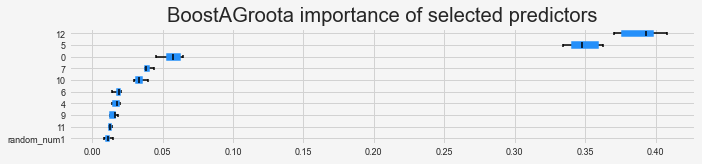

==================== BoostAGroota - testing: <catboost.core.CatBoostRegressor object at 0x0000018F773ED608> ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.

The feature selection BoostARoota running time is     1.03 min
0     0
1     2
2     4
3     5
4     6
5     7
6     9
7    10
8    11
9    12
Name: feature, dtype: object


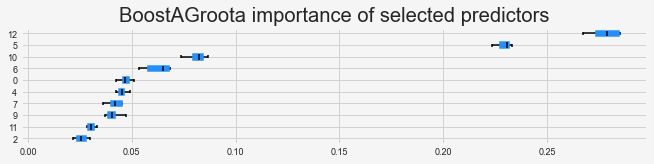

==================== BoostAGroota - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbose=0, verbosity=None) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2


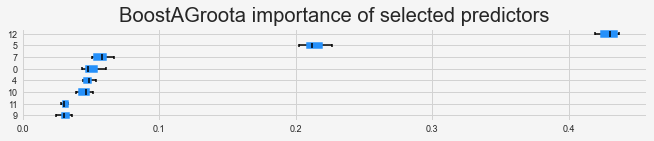

==================== BoostAGroota - testing:                   LGBMRegressor(random_state=42, verbose=-1) ====================
Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
Round:  4  iteration:  1
Round:  4  iteration:  2
Round:  4  iteration:  3
Round:  4  iteration:  4
Round:  4  iteration

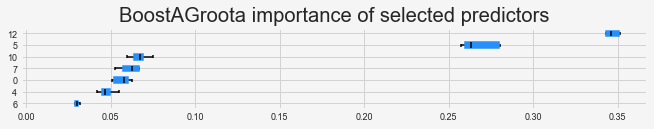

==================== BoostAGroota - testing: LGBMRegressor(bagging_fraction=0.632, bagging_freq=1, boosting_type='rf',
              feature_fraction=0.3333333333333333, force_col_wise=True,
              verbose=-1) ====================
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Round:  1  iteration:  1
[LightGBM] [Warning] feature_fraction is set=0.3333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3333333333333333
[LightGBM] [Warning] bagging_fraction is set=0.632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. C

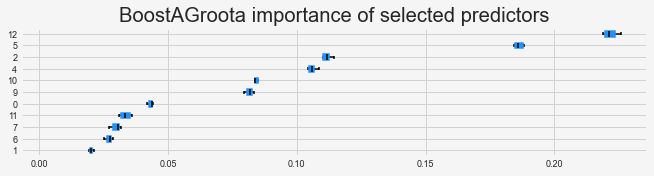

In [8]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(models, X, y, sample_weight=None):
    for model in models:
        print('='*20 + ' BoostAGroota - testing: {mod:>60} '.format(mod=str(model)) +'='*20 )
        feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, silent=False, imp='shap')
        feat_selector.fit(X, y)
        print(feat_selector.keep_vars_ )
        feat_selector.plot_importance()
        gc.enable()
        del(feat_selector, model)
        gc.collect()

def testing_clf_all_varimp(X, y, sample_weight=None):
    models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
              catboost.CatBoostClassifier(random_state=42, verbose=0), 
              XGBClassifier(random_state=42, verbose=0), 
              LGBMClassifier(random_state=42, verbose=-1),
              LightForestClassifier(n_feat=X.shape[1])]
    testing_estimators(models=models, X=X, y=y, sample_weight=sample_weight)
    gc.enable()
    del(models)
    gc.collect()

def testing_regr_all_varimp(X, y):
    models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
              catboost.CatBoostRegressor(random_state=42, verbose=0), 
              XGBRegressor(random_state=42, verbose=0), 
              LGBMRegressor(random_state=42, verbose=-1),
              LightForestRegressor(n_feat=X.shape[1])]
    testing_estimators(models=models, X=X, y=y)
    gc.enable()
    del(models)
    gc.collect()
        
if __name__ == '__main__':
    # classification and cat. pred, sample weight is just a dummy random vector for testing purpose
    X, y, sample_weight= get_titanic_data()
    testing_clf_all_varimp(X=X, y=y, sample_weight=sample_weight)
    # classification and cat. pred
    X, y = get_cancer_data()
    testing_clf_all_varimp(X=X, y=y)
    # regression
    X, y = get_boston_data()
    testing_regr_all_varimp(X=X, y=y)